In [1]:
import sys
import os
from pathlib import Path
os.environ['http_proxy'] = "http://127.0.0.1:20171" 
os.environ['https_proxy'] = "http://127.0.0.1:20171" 

module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path+"/controlnet")
    sys.path.append(module_path+"/ov_pipelines")

In [2]:
from controlnet_aux import OpenposeDetector
from ov_pipelines import OpenPoseOVModel
import openvino as ov

pose_estimator = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

OPENPOSE_OV_PATH = Path("openpose.xml")
core = ov.Core()
ov_openpose = OpenPoseOVModel(core, OPENPOSE_OV_PATH, device='CPU')
pose_estimator.body_estimation.model = ov_openpose

/home/yongsheng/miniconda3/envs/gsoc/lib/python3.11/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/yongsheng/miniconda3/envs/gsoc/lib/python3.11/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_5m_224. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  return register_model(fn_wrapper)
/home/yongsheng/miniconda3/envs/gsoc/lib/python3.11/site-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_11m_224 in registry with controlnet_aux.segment_anything.modeling.tiny_vit_sam.tiny_vit_11m_224. This is because the name being reg

In [3]:
# pose = pose_estimator(img)
# fig = visualize_pose_results(img, pose)

In [4]:
CONTROLNET_OV_PATH = Path("controlnet-pose.xml")

In [5]:
UNET_OV_PATH = Path("unet_controlnet.xml")

In [6]:
TEXT_ENCODER_OV_PATH = Path("text_encoder.xml")

In [7]:
VAE_DECODER_OV_PATH = Path("vae_decoder.xml")

In [8]:
import torch
# from diffusers import StableDiffusionControlNetPipeline
# from controlnet import ControlNetModel

# controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_openpose", torch_dtype=torch.float32)
# pipe = StableDiffusionControlNetPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", controlnet=controlnet)

# print(pipe.scheduler.config)

from transformers import CLIPTokenizer
from diffusers import UniPCMultistepScheduler, LMSDiscreteScheduler

# scheduler_config = {"num_train_timesteps": 1000, "beta_start": 0.00085, "beta_end": 0.012, "beta_schedule": "scaled_linear", "trained_betas": None, "skip_prk_steps": True, "set_alpha_to_one": False, "prediction_type": "epsilon", "timestep_spacing": "leading", "steps_offset": 1, "_use_default_values": ["prediction_type", "timestep_spacing"], "_class_name": "PNDMScheduler", "_diffusers_version": "0.6.0", "clip_sample": False}
# scheduler = UniPCMultistepScheduler.from_config(scheduler_config)

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

scheduler_config = {"num_train_timesteps": 1000, "beta_start": 0.00085, "beta_end": 0.012, "beta_schedule": "scaled_linear"}
scheduler = LMSDiscreteScheduler.from_config(scheduler_config)

In [9]:
# import json

# json.dumps(pipe.scheduler.config)

In [10]:
from ov_pipelines import OVContrlNetStableDiffusionPipeline
ov_pipe = OVContrlNetStableDiffusionPipeline(
    tokenizer,
    scheduler,
    core,
    CONTROLNET_OV_PATH,
    TEXT_ENCODER_OV_PATH,
    UNET_OV_PATH,
    VAE_DECODER_OV_PATH,
    device='CPU',
)

/home/yongsheng/miniconda3/envs/gsoc/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `unet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'unet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.unet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


14.614646911621094


  0%|          | 0/20 [00:00<?, ?it/s]

/home/yongsheng/miniconda3/envs/gsoc/lib/python3.11/site-packages/diffusers/configuration_utils.py:139: FutureWarning: Accessing config attribute `controlnet` directly via 'OVContrlNetStableDiffusionPipeline' object attribute is deprecated. Please access 'controlnet' over 'OVContrlNetStableDiffusionPipeline's config object instead, e.g. 'scheduler.config.controlnet'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


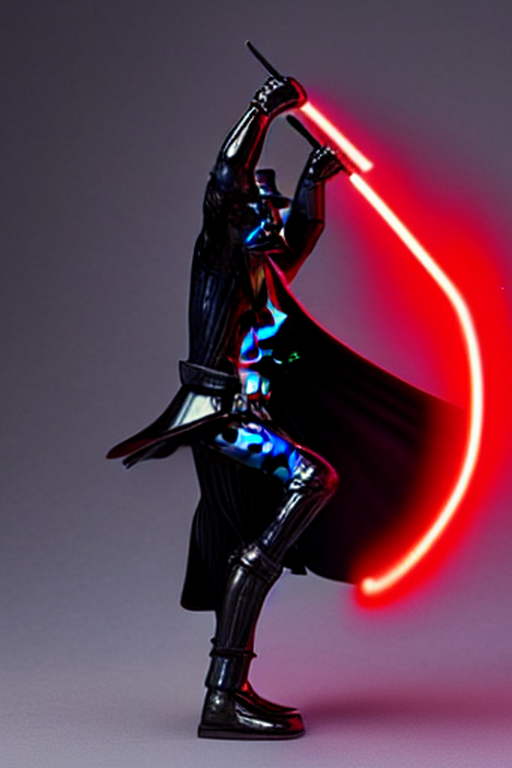

In [11]:
import numpy as np
from PIL import Image

img = Image.open("pose.png")

np.random.seed(42)

pose = pose_estimator(img)

prompt = "Dancing Darth Vader, best quality, extremely detailed"
negative_prompt = "monochrome, lowres, bad anatomy, worst quality, low quality"
result = ov_pipe(prompt, pose, 20, negative_prompt=negative_prompt)

result[0]